In [27]:
import numpy as np
from obspy import read
from obspy.taup import TauPyModel
from obspy.core import Stream
from glob import glob 
from math import floor
from geographiclib.geodesic import Geodesic
import matplotlib.pyplot as plt
import os
from acc.stack import linear_stack,pws_stack
from obspy import read
import pylops

In [28]:
##load data
datadir = 'Varyp_no_lowercrust_with_sediment'
st_auto = read(f"{datadir}/ray*_gauss*.ZAC.SAC")
ray_params = []
for tr_auto in st_auto:
    ray_params.append(tr_auto.stats.sac['user0'])



In [29]:
##phase weighting stack along ray_parameter bin
bin_width = 0.005
bin_dis = 0.001
ray_param_min = min(ray_params)
ray_param_max = max(ray_params)
ray_param_bin = ray_param_min
stack_save_dir = f"{datadir}/stack"
import os
if not os.path.isdir(stack_save_dir):
    os.makedirs(stack_save_dir)
while ray_param_bin <=ray_param_max:
    st_stack = Stream()
    for j, ray_param in enumerate(ray_params):
        if ray_param>ray_param_bin-bin_width/2.0 and ray_param<ray_param_bin+bin_width/2.0:
            st_stack.append(st_auto[j])
    tr_stack = pws_stack(st_stack,power=2)
    tr_stack.stats.sac['user0']=ray_param_bin
    tr_stack.write(f"{stack_save_dir}/stack{ray_param_bin:6.5f}.ZAC.SAC")
    ray_param_bin += bin_dis




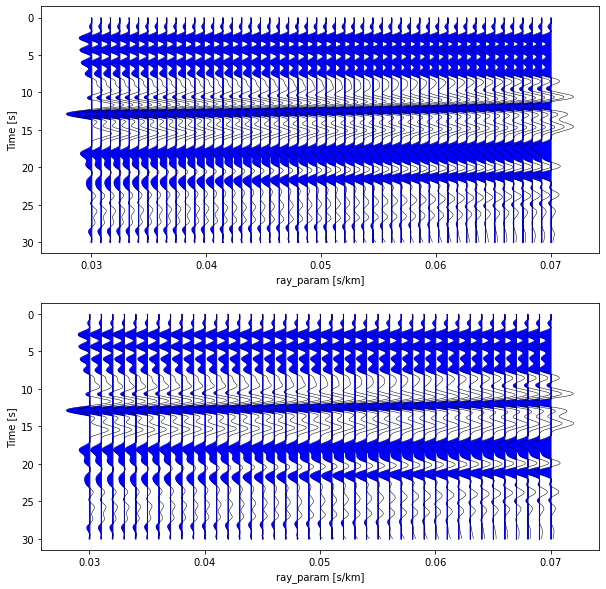

In [30]:
##plot ACs before and after phase-weight stacking

fig = plt.figure(figsize=(10,10))
ax_before = fig.add_subplot(211)
ax_after = fig.add_subplot(212)

st_ac_before_stack = read(f"{datadir}/ray*_gauss*.ZAC.SAC")
st_ac_after_stack = read(f"{stack_save_dir}/stack*.ZAC.SAC")

pltlength = 30
normalized_scale=0.002
for tr in st_ac_before_stack:
    delta = tr.stats.delta
    gcarc = tr.stats.sac['user0']
    pltnpts = int(pltlength/delta)
    autocorr_t_w = tr.data[:pltnpts]
    times = np.arange(len(autocorr_t_w))*delta
    ax_before.plot(autocorr_t_w*normalized_scale+gcarc,times,lw=0.5,c='k')
    fill = autocorr_t_w.copy()
    fill[fill>0] = 0
    ax_before.fill_betweenx(times,fill*normalized_scale+gcarc,gcarc,color='blue')
ax_before.invert_yaxis()
ax_before.set_xlabel('ray_param [s/km]')
ax_before.set_ylabel('Time [s]')

normalized_scale=0.002
for tr in st_ac_after_stack:
    delta = tr.stats.delta
    gcarc = tr.stats.sac['user0']
    pltnpts = int(pltlength/delta)
    autocorr_t_w = tr.data[:pltnpts]
    times = np.arange(len(autocorr_t_w))*delta
    ax_after.plot(autocorr_t_w*normalized_scale+gcarc,times,lw=0.5,c='k')
    fill = autocorr_t_w.copy()
    fill[fill>0] = 0
    ax_after.fill_betweenx(times,fill*normalized_scale+gcarc,gcarc,color='blue')
ax_after.invert_yaxis()
ax_after.set_xlabel('ray_param [s/km]')
ax_after.set_ylabel('Time [s]')


plt.show()

In [31]:
##radon transform
import time


length = 30

ACs= []
ray_params = []
for tr in st_ac_after_stack:
    starttime = tr.stats.starttime
    tr = tr.slice(starttime,starttime+length)
    ACs.append(tr.data)
    ray_params.append(tr.stats.sac['user0'])

AC_para = zip(ACs,ray_params)
AC_para = sorted(AC_para,key=lambda x:x[1])
ACs,ray_params = zip(*AC_para)

ACs = np.stack(ACs,axis = 0)

##set up radon operator
ray_params = np.array(ray_params)
times = np.arange(ACs.shape[1])*tr.stats.delta
ps = np.linspace(-50,50,101)
Rop = pylops.signalprocessing.Radon2D(
    times, ray_params, ps, kind='linear', interp='nearest', centeredh=False, dtype='float64'
     )

##sparse Radon transform 
xinv, niter, cost = pylops.optimization.sparsity.fista(
    Rop, ACs.ravel(), niter=15, eps=1e1
)
xinv = xinv.reshape(Rop.dims)

##filter at t-p domain
xinv_filter = np.zeros_like(xinv)
index_ = ps<-10
xinv_filter[index_] = xinv[index_]

## transform to t-x domain
ACs_filter = Rop*xinv_filter


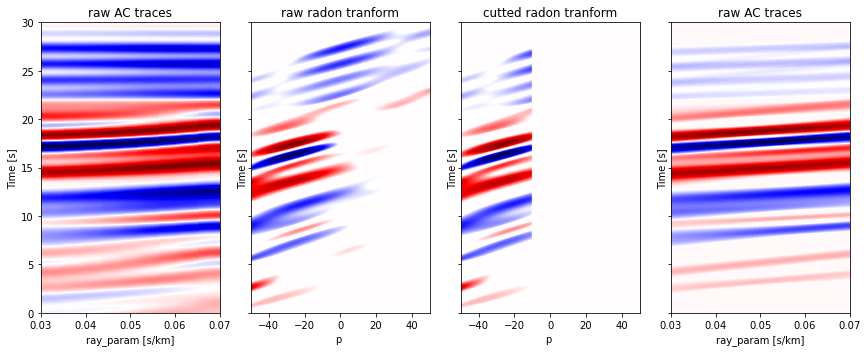

In [32]:
fig, axs = plt.subplots(1,4,sharey=True, figsize=(12,5))
##plot raw AC traces
axs[0].imshow(
    ACs.T,
    cmap = 'seismic',
    vmin = ACs.min(),
    vmax = ACs.max(),
    extent=(ray_params.min(),ray_params.max(),times.min(),times.max())
)


axs[0].axis("tight")
axs[0].set_xlabel('ray_param [s/km]')
axs[0].set_ylabel('Time [s]')
axs[0].set_title('raw AC traces')

##plot radon transform of raw traces
axs[1].imshow(
    xinv.T,
    cmap = 'seismic',
    vmin = xinv.min(),
    vmax = xinv.max(),
    extent=(ps.min(),ps.max(),times.min(),times.max())
)
axs[1].axis("tight")
axs[1].set_xlabel('p ')
axs[1].set_ylabel('Time [s]')
axs[1].set_title('raw radon tranform')

##plot cutted radon transform of raw traces
axs[2].imshow(
    xinv_filter.T,
    cmap = 'seismic',
    vmin = xinv_filter.min(),
    vmax = xinv_filter.max(),
    extent=(ps.min(),ps.max(),times.min(),times.max())
)
axs[2].axis("tight")
axs[2].set_xlabel('p ')
axs[2].set_ylabel('Time [s]')
axs[2].set_title('cutted radon tranform')


##plot filtered AC traces
axs[3].imshow(
    ACs_filter.T,
    cmap = 'seismic',
    vmin = ACs_filter.min(),
    vmax = ACs_filter.max(),
    extent=(ray_params.min(),ray_params.max(),times.min(),times.max())
)
axs[3].axis("tight")
axs[3].set_xlabel('ray_param [s/km]')
axs[3].set_ylabel('Time [s]')
axs[3].set_title('raw AC traces')

plt.tight_layout()